# Prelude

In [1]:
import sys
import pathlib as pl
sys.path.insert(0,str(pl.Path("../").absolute()))

In [2]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn # neuronal layers, function objects
import torch.nn.functional as F # contains activation functions
from torch.autograd import Variable # wrapper for tensor
import torch.optim as opt
import numpy as np
import sklearn.preprocessing as skp
from utils.data_loader import load_data
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass, asdict
from typing import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda


In [4]:
data_temp, data_wind = load_data()
display(data_temp.head(3))
display(data_wind.head(3))

,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:42,526487,467544,442
1,2022-01-22 13:53:44,526542,467315,461
2,2022-01-22 13:53:45,526532,466868,466


,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:37,505940,507749,621
1,2022-01-22 13:53:38,505846,507807,632
2,2022-01-22 13:53:40,505990,507764,629


Functions for Preprocessing

In [5]:
def scale_and_resample_timeindex(df: pd.DataFrame, timefreq="10s", aggregator="mean"):
    df = df.set_index("timestamp")
    df = df[~df.index.duplicated(keep="first")]
    df = df.resample(timefreq).aggregate(aggregator)
    scaler = skp.MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    return df, scaler

def time_indexed_data_to_sliding_window(df: pd.DataFrame, window_size=5):
    n_rows = df.shape[0]
    df = df.reset_index()
    windows = []
    for i in tqdm(range(n_rows-window_size)):
        window = df.loc[i:i+window_size-1,:]
        windows.append(np.array(window))


    return windows, ["batch", *df.columns]

# returns format batch, len_x observations, label is next window_size-len_x observations
def convert_to_feature_labels(windows: list[np.ndarray], len_x = 10): # len_x < window_size, discards timestamp
    windows = [w[:,1:].astype(float) for w in windows] # reject timestamp (at col 0)
    valid_windows = [w for w in windows if not np.isnan(w).any()]
    features = [w[:len_x,:] for w in valid_windows]
    labels = [w[len_x:] for w in valid_windows]
    return np.array(features), np.array(labels)

# Experimentation

## Data Preprocessing

convert data to sample with same time interval spacing

In [6]:
data_resampled, scaler = scale_and_resample_timeindex(data_temp, timefreq="10s", aggregator="mean")
data_resampled.head(3)

,differential_potential_CH1,differential_potential_CH2,transpiration
timestamp,,,
2022-01-22 13:53:40,0.836353,0.536408,0.718769
2022-01-22 13:53:50,0.838699,0.519598,0.726964
2022-01-22 13:54:00,0.839003,0.520106,0.721901


Save resampled data for further use and analysis

In [7]:
dir = pl.Path("../data/preprocessed/")
dir.mkdir(exist_ok=True)
data_resampled.to_csv(dir / "resampled.csv")


Visualize resampled data

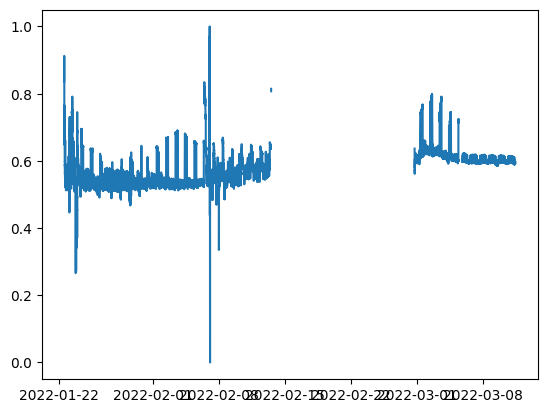

In [8]:
fig, ax = plt.subplots()
ax.plot(data_resampled.index.to_numpy(), data_resampled["differential_potential_CH1"].to_numpy())
plt.show()

apply sliding window to extract labeled data set

In [9]:

data, column_names = time_indexed_data_to_sliding_window(data_resampled, window_size=15)
display(len(data), "window example:", pd.DataFrame(data[0], columns=column_names[1:]))

100%|██████████| 413124/413124 [00:53<00:00, 7673.53it/s]


413124

'window example:'

,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:40,0.836353,0.536408,0.718769
1,2022-01-22 13:53:50,0.838699,0.519598,0.726964
2,2022-01-22 13:54:00,0.839003,0.520106,0.721901
3,2022-01-22 13:54:10,0.842335,0.518108,0.714783
4,2022-01-22 13:54:20,0.843746,0.517209,0.70977
5,2022-01-22 13:54:30,0.912409,0.512693,0.709811
6,2022-01-22 13:54:40,0.874138,0.513865,0.715529
7,2022-01-22 13:54:50,0.870078,0.515041,0.709123
8,2022-01-22 13:55:00,0.873781,0.515778,0.711634
9,2022-01-22 13:55:10,0.870343,0.515506,0.716813


save window for later use

In [10]:
dir = pl.Path("../data/preprocessed/")
dir.mkdir(exist_ok=True)
np.save(dir / "window_data",data)
pd.DataFrame(column_names).T.to_csv(dir / "window_columns.csv", index=False,header=False)

convert windows to X, Y  data points and reject datapoints that contain nan

In [11]:
features, labels = convert_to_feature_labels(data, len_x=4)   
display(features.shape, labels.shape)
features[0], labels[0]

(277885, 4, 3)

(277885, 11, 3)

(array([[0.83635333, 0.53640751, 0.71876864],
        [0.83869946, 0.51959845, 0.72696387],
        [0.83900298, 0.52010564, 0.72190089],
        [0.84233506, 0.51810784, 0.7147829 ]]),
 array([[0.84374593, 0.51720851, 0.70976964],
        [0.91240873, 0.51269286, 0.70981107],
        [0.87413821, 0.51386521, 0.71552867],
        [0.87007835, 0.51504076, 0.7091233 ],
        [0.87378132, 0.51577775, 0.71163407],
        [0.87034251, 0.5155062 , 0.71681306],
        [0.86655682, 0.51455284, 0.71809745],
        [0.86607185, 0.52045778, 0.71409513],
        [0.85952577, 0.52036639, 0.72124627],
        [0.81645226, 0.52726468, 0.71867749],
        [0.83448016, 0.52653763, 0.72377362]]))

## Demo Simple Network
For experimentation with pytorch, define a simple network and train data on it

define encoder

In [12]:
# adapted from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term) # TODO: why does this crash when d_model = 3?
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Encoder(nn.Module):
    def __init__(self, d_input, d_model):
        super(Encoder, self).__init__()

        # define layers (layers are functions)
        self.input_layer = nn.Linear(d_input, d_model) # input layer, 10 features in, 10 features out (== keras dense)
        self.pos_encoding_layer = PositionalEncoding(d_model,dropout=0.2)
        self.encoder_layers = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=1, dropout=0.2), num_layers=4) # stacks multiple encoder layers, contains self attention and feed forward with normalization in between, TODO: how many heads?

    # forward pass data x through network
    def forward(self, x: torch.Tensor):
        x = self.input_layer(x)
        x = self.pos_encoding_layer(x)
        x = self.encoder_layers(x)
        return x[0] # we ignore batching here, expected shape of x: [batch][pos in seq][dim]

demo_data_input = torch.Tensor(features[0][:5,:]).to(device)
print("src shape is [pos in sequence][dimension]",demo_data_input.shape)
d_input = demo_data_input.shape[1] # columns as input dimension
d_model = 2 #TODO: why only even numbers?
model = Encoder(d_input=d_input, d_model=d_model)
model.to(device)


memory = model(demo_data_input)
print(f"memory shape is {memory.shape} [pos in seq][dim]")


src shape is [pos in sequence][dimension] torch.Size([4, 3])
memory shape is torch.Size([4, 2]) [pos in seq][dim]


In [13]:
display(demo_data_input)
demo_data_input.shape, memory.shape

tensor([[0.8364, 0.5364, 0.7188],
        [0.8387, 0.5196, 0.7270],
        [0.8390, 0.5201, 0.7219],
        [0.8423, 0.5181, 0.7148]], device='cuda:0')

(torch.Size([4, 3]), torch.Size([4, 2]))

define decoder

In [14]:
def get_mask(dim1: int, dim2: int) -> torch.Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Modified from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    Args:

        dim1: int, for both src and tgt masking, this must be target sequence
              length

        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 


    Return:

        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)

class Decoder(nn.Module):
    def __init__(self, d_input, d_model):
        super(Decoder, self).__init__()

        # define layers (layers are functions)
        self.input_layer = nn.Linear(d_input, d_model) # input layer, 10 features in, 10 features out (== keras dense)
        self.decoder_layers = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=d_model, nhead=1, dropout=0.2), num_layers=4)
        self.linear_mapping = nn.Linear(
            in_features=d_model, 
            out_features=d_input
            )


    # forward pass data x through network
    def forward(self, x: torch.Tensor, memory: torch.Tensor, mask: torch.Tensor): #NOTE: TODO: implement Masking
        x = self.input_layer(x)
        x = self.decoder_layers(x,memory=memory,tgt_mask=mask)
        x = self.linear_mapping(x)
        return x
    
#demo_data_target = torch.Tensor(features[0][2:3,:]).to(device)
#demo_data_target = torch.Tensor(np.empty((0,3))).to(device)
demo_data_target = demo_data_input[-1:,:] # use last input as first input (this would be done in inference?)
#demo_data_memory = torch.Tensor(features[0][2:3,:]).to(device)
mask = get_mask(demo_data_target.shape[0], demo_data_target.shape[0]).to(device)
d_input = demo_data_target.shape[1] # columns as input dimension
d_model = memory.shape[1] # needs to be equal?
model = Decoder(d_input=d_input, d_model=d_model)
model.to(device)


out = model(demo_data_target, memory, None)
print(out)

tensor([[ 0.1180,  0.0826, -1.1873]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [15]:
demo_data_target.shape, memory.shape

(torch.Size([1, 3]), torch.Size([4, 2]))

In [16]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_input, d_model):
        super(TimeSeriesTransformer, self).__init__()

        # define layers
        self.encoder = Encoder(d_input, d_model)
        self.decoder = Decoder(d_input, d_model)

    def forward(self, src: torch.Tensor, target: torch.Tensor, mask: torch.Tensor):
        src = self.encoder(src)
        out = self.decoder(x=target,memory=src, mask=mask)
        return out
    
#demo_data_input = torch.Tensor(features[0][:1,:]).to(device)
#demo_data_target = torch.Tensor(features[0][2:3,:]).to(device)
#d_input = demo_data_input.shape[1] # columns as input dimension
#d_model = d_input
model = TimeSeriesTransformer(d_input=d_input, d_model=d_model)
model.to(device)

mask = get_mask(demo_data_target.shape[0],demo_data_target.shape[0]).to(device)
prediction = model(demo_data_input, demo_data_target, mask)
print(f"input\t\t\t{demo_data_input}")
print(f"target\t\t\t{demo_data_target}")
print(f"mask\t\t\t{mask}")
print(f"prediction\t\t{prediction}")

input			tensor([[0.8364, 0.5364, 0.7188],
        [0.8387, 0.5196, 0.7270],
        [0.8390, 0.5201, 0.7219],
        [0.8423, 0.5181, 0.7148]], device='cuda:0')
target			tensor([[0.8423, 0.5181, 0.7148]], device='cuda:0')
mask			tensor([[0.]], device='cuda:0')
prediction		tensor([[ 0.5884,  0.5479, -1.0371]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [17]:
demo_data_input.shape, demo_data_target.shape, mask

(torch.Size([4, 3]), torch.Size([1, 3]), tensor([[0.]], device='cuda:0'))

Network Training

In [18]:
print(f"we have {features.shape[0]} individual windows to train from")
print(f"each window has shape {features.shape[1:]}")
print(f"structure of data [window_nr][point_in_seq][feature]: {features.shape}")
print(f"structure of labels [window_nr][point_in_seq][feature]: {labels.shape}")

we have 277885 individual windows to train from
each window has shape (4, 3)
structure of data [window_nr][point_in_seq][feature]: (277885, 4, 3)
structure of labels [window_nr][point_in_seq][feature]: (277885, 11, 3)


In [20]:
#%%
net = TimeSeriesTransformer(d_input, d_model)
net.to(device)
#print(net)
learning_rate = 0.0001
optimizer = opt.SGD(net.parameters(), lr=learning_rate) # default stochastic gradient descent
#%%
losses = []
# go through every datapoint (1)
for i in tqdm(range(100)):
#for i in tqdm(range(features.shape[0]), file=sys.stdout):
    # main training loop / pipeline
    # get window
    wFeatures = features[i] # [step in sequence][feature]
    wLabels = labels[i] # [step in sequence][feature]
    window = np.concatenate((wFeatures,wLabels), axis=0)
    fLen = wFeatures.shape[0]
    lLen = wLabels.shape[0]
    # train every step in window individually
    for sp in range(lLen):
        #input, target, mask:
        X = window[:fLen+sp,:]
        X = torch.Tensor(X).to(device)
        target = X[-1:,:] # start with latest entry
        target = torch.Tensor(target).to(device)
        Y = window[fLen+sp:,:]
        Y = torch.Tensor(Y).to(device)
        mask = get_mask(target.shape[0],target.shape[0]).to(device)
        # forward pass  
        #print(X.shape, target.shape, mask.shape, Y.shape)
        out = net(X,target,mask)
        loss = F.mse_loss(out, Y[0,:]) # should predict next step  

        # backpropagation
        loss.backward()
        optimizer.step()
        losses.append(float(loss))
#%%
# example result of trained net and conversion to numpy
#x_numpy = np.array([1,0,0,0,1,0,0,0,1,1])
#x = torch.Tensor(x_numpy).to(net.device)
#y = net(x)
#y_numpy = y.detach().cpu().numpy()
#print("in  ", x_numpy.astype(np.int8))
#print("out ", np.abs(np.rint(y_numpy)).astype(np.int8)) # as nearest (positive) int
# %%
prediction = model(demo_data_input, demo_data_target, mask=None)
print(f"input\t\t\t{demo_data_input}")
print(f"target\t\t\t{demo_data_target}")
print(f"prediction\t\t{prediction}")
print(demo_data_input.shape, demo_data_target.shape, prediction.shape)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Julian\AppData\Local\Temp\ipykernel_18852\2883315415.py:32: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, Y[0,:]) # should predict next step
100%|██████████| 100/100 [00:21<00:00,  4.74it/s]

input			tensor([[0.8364, 0.5364, 0.7188],
        [0.8387, 0.5196, 0.7270],
        [0.8390, 0.5201, 0.7219],
        [0.8423, 0.5181, 0.7148]], device='cuda:0')
target			tensor([[0.8423, 0.5181, 0.7148]], device='cuda:0')
prediction		tensor([[ 0.7378, -1.0145, -0.3277]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
torch.Size([4, 3]) torch.Size([1, 3]) torch.Size([1, 3])


In [21]:
dir = pl.Path("../data/experiment/")
dir.mkdir(exist_ok=True)
torch.save(net.state_dict(), dir / 'model_weights.pt')
losses = np.array(losses)
np.save(dir / "losses",losses)
torch.save({"d_input":d_input, "d_model": d_model}, dir / "model_params.pt")

# Some Playaround with Dataset to Feature Functions

Findings:
 - timefreq="1d", window_size=14, len_x = 4 seems interesting

In [22]:
def prepare_dataset(data:pd.DataFrame, timefreq="1min", aggregator="mean", window_size=15, len_x=4):
    print("resampling")
    data_resampled, scaler = scale_and_resample_timeindex(data, timefreq=timefreq, aggregator=aggregator)
    print("sliding window")
    data, column_names = time_indexed_data_to_sliding_window(data_resampled, window_size=window_size)
    print("window to labels")
    features, labels = convert_to_feature_labels(data, len_x=len_x) 
    return features, labels, column_names[2:], scaler

features, labels, column_names, scaler = prepare_dataset(data_temp, timefreq="1min", aggregator="mean", window_size=10, len_x = 8)
display(features.shape, labels.shape)

resampling
sliding window


100%|██████████| 68848/68848 [00:08<00:00, 7936.35it/s]


window to labels


(46291, 8, 3)

(46291, 2, 3)

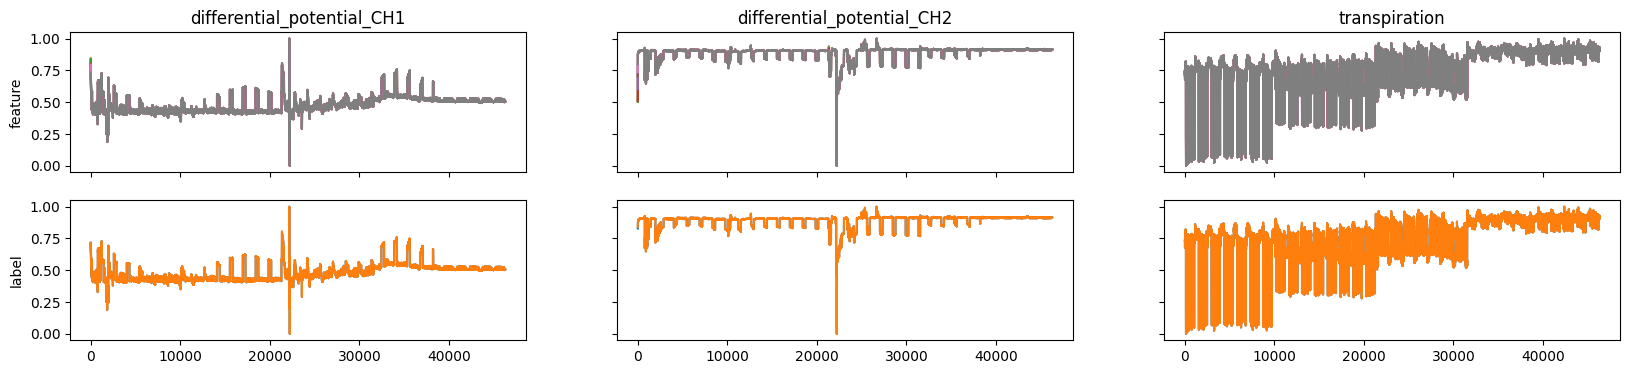

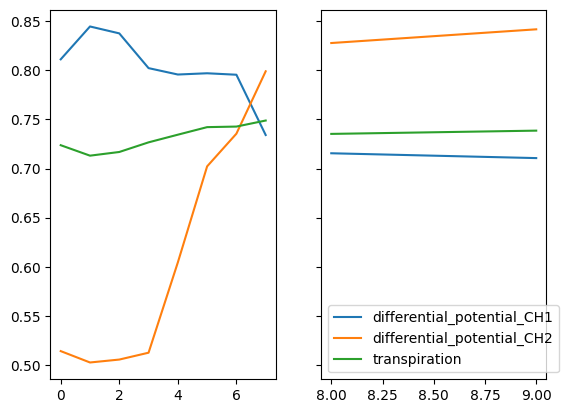

In [23]:
def visualize_dataset(features, labels, column_names):
    fig, ax = plt.subplots(2,features.shape[2], sharey=True, sharex=True)
    fig.set_figwidth(20)
    fig.set_figheight(4)
    ax[0,0].set_ylabel("feature")
    ax[1,0].set_ylabel("label")
    for i in range(features.shape[2]):
        axi :plt.Axes = ax[0,i]
        axi.set_title(column_names[i])
        ax[0,i].plot(list(range(features.shape[0])), features[:, :,i]) # TODO: not sure what actually gets displayed here

        ax[1,i].plot(list(range(labels.shape[0])), labels[:, :,i])

    plt.show()

def visualize_feature(feature, label, column_names):
    fig, ax = plt.subplots(1,2, sharey=True)
    for i in range(feature.shape[1]):
        ax[0].plot(list(range(feature.shape[0])), feature[:, i], label=column_names[i])
        ax[1].plot(feature.shape[0]+np.array(range(label.shape[0])), label[:, i], label=column_names[i])
    plt.legend(loc="lower left")
    plt.show()



visualize_dataset(features, labels, column_names)
visualize_feature(features[0], labels[0],column_names)

In [24]:
column_names

['differential_potential_CH1', 'differential_potential_CH2', 'transpiration']

In [26]:
data = data_temp.copy().iloc[:1000,:]
timefreq="5s"
aggregator="mean"
window_size=12
feature_size=10

def get_window(data, i, wsize):
    window = data.iloc[i:i+wsize, 1:].to_numpy()
    timestamps = data.iloc[i:i+wsize, 0].to_numpy()
    isvalid = not np.any(np.isnan(window))
    if window.shape[0] != wsize:
        isvalid = False
    return window, timestamps, isvalid

def get_datapoint(data, i, wsize, fsize):
    window, timestamps, isvalid = get_window(data, i, wsize)
    feature, label = window[0:fsize,:], window[fsize:,:]
    return feature, label, timestamps, isvalid

def get_valid_windows(data, wsize):
    valid_indexes = []
    print("computing valid windows")
    for i in tqdm(range(data.shape[0])):
        _,_, isvalid = get_window(data,i,wsize)
        if isvalid:
            valid_indexes.append(i)
    print(f"found {len(valid_indexes)} valid window(s)")
    return valid_indexes

data_resampled, scaler = scale_and_resample_timeindex(data, timefreq=timefreq, aggregator=aggregator)
data_resampled = data_resampled[["differential_potential_CH1"]]
data_resampled = data_resampled.reset_index()
valid_windows = get_valid_windows(data_resampled, window_size)
window, timestamps, isvalid = get_window(data_resampled, valid_windows[0],window_size)
feature, label, timestamps, isvalid = get_datapoint(data_resampled, valid_windows[0], window_size, feature_size)




computing valid windows


100%|██████████| 348/348 [00:00<00:00, 5271.59it/s]

found 337 valid window(s)


In [27]:
@dataclass(frozen=True,slots=True)
class ExperimentData:
    data_resampled: pd.DataFrame
    scaler: skp.MinMaxScaler
    timefreq: str
    aggregator: str|Callable
    columns: list[str]
    window_size: int
    feature_size: int
    valid_windows: list[int]

@dataclass(frozen=True, slots=True)
class TrainingData:
    net: TimeSeriesTransformer
    d_input: int
    d_model: int
    seed: int|None
    learning_rate: float
    epoch_size: float
    losses: list[float]


def getExperimentData(data, timefreq, aggregator, columns, window_size, feature_size):
    data_resampled, scaler = scale_and_resample_timeindex(data, timefreq=timefreq, aggregator=aggregator)
    data_resampled = data_resampled[columns]
    data_resampled = data_resampled.reset_index()
    valid_windows = get_valid_windows(data_resampled, window_size)
    #feature, label, timestamps, isvalid = get_datapoint(data_resampled, valid_windows[0], window_size, feature_size) 
    return ExperimentData(data_resampled, scaler, timefreq, aggregator, columns, window_size, feature_size, valid_windows)

def trainExperiment(data: ExperimentData, d_model, learning_rate, epoch_size, seed):
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
    #%%
    d_input = len(data.columns)
    net = TimeSeriesTransformer(d_input, d_model)
    net.to(device)
    #print(net)
    optimizer = opt.SGD(net.parameters(), lr=learning_rate) # default stochastic gradient descent
    #%%
    losses = []
    print("start training")
    # go through every datapoint (1)
    for i in tqdm(range(epoch_size)):
    #for i in tqdm(range(features.shape[0]), file=sys.stdout):
        # main training loop / pipeline
        net.zero_grad() # net accumulates errors and needs to be reset manually each step
        # get window
        X = torch.Tensor(feature).to(device)
        Y = torch.Tensor(label).to(device)
        mask = get_mask(Y.shape[0],Y.shape[0]).to(device)
        # forward pass  
        #print(X.shape, target.shape, mask.shape, Y.shape)
        out = net(X,Y,mask)
        loss = F.mse_loss(out, Y) # should predict next step  

        # backpropagation
        loss.backward()
        optimizer.step()
        losses.append(float(loss))
    #%%
    # example result of trained net and conversion to numpy
    #x_numpy = np.array([1,0,0,0,1,0,0,0,1,1])
    #x = torch.Tensor(x_numpy).to(net.device)
    #y = net(x)
    #y_numpy = y.detach().cpu().numpy()
    #print("in  ", x_numpy.astype(np.int8))
    #print("out ", np.abs(np.rint(y_numpy)).astype(np.int8)) # as nearest (positive) int
    # %%
    prediction = model(demo_data_input, demo_data_target, mask=None)
    print(f"input\t\t\t{demo_data_input}")
    print(f"target\t\t\t{demo_data_target}")
    print(f"prediction\t\t{prediction}")
    print(demo_data_input.shape, demo_data_target.shape, prediction.shape)
    return TrainingData(net, d_input, d_model, seed, learning_rate, epoch_size, losses)

def saveData(dir: pl.Path, expData: ExperimentData, trainData: TrainingData):
    dir.mkdir(exist_ok=True)
    torch.save(trainData.net.state_dict(), dir / 'model_weights.pt')
    losses = np.array(trainData.losses)
    np.save(dir / "losses",losses)
    torch.save({"d_input":trainData.d_input, "d_model": trainData.d_model}, dir / "model_params.pt")
    dc = asdict(expData)
    dc["data_resampled"] = None
    torch.save(dc, dir / "exp_data.pt")
    print("data saved")

# expData = getExperimentData(
#     data_temp.copy().iloc[:1000,:],
#     timefreq="5s",
#     aggregator="mean",
#     columns=["transpiration"],
#     window_size=12,
#     feature_size=10)

#trainData = trainExperiment(expData, 6, 0.0001, 1000, 0)
#saveData(pl.Path("../data/experiment/"), expData, trainData)



computing valid windows


100%|██████████| 348/348 [00:00<00:00, 5522.66it/s]


found 337 valid window(s)


100%|██████████| 1000/1000 [00:20<00:00, 49.40it/s]

input			tensor([[0.8364, 0.5364, 0.7188],
        [0.8387, 0.5196, 0.7270],
        [0.8390, 0.5201, 0.7219],
        [0.8423, 0.5181, 0.7148]], device='cuda:0')
target			tensor([[0.8423, 0.5181, 0.7148]], device='cuda:0')
prediction		tensor([[ 0.5884,  0.5479, -1.0371]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
torch.Size([4, 3]) torch.Size([1, 3]) torch.Size([1, 3])
data saved


In [28]:
# data = expData
# window_index = data.valid_windows[int(np.random.uniform(0,len(data.valid_windows)))]
# feature, label, _timestamps, _isvalid = get_datapoint(data.data_resampled, window_index,data.window_size,data.feature_size)
# feature, label

(array([[0.12015694],
        [0.06768024],
        [0.07994115],
        [0.088769  ],
        [0.05934282],
        [0.16429622],
        [0.28298185],
        [0.212359  ],
        [0.25159392],
        [0.18538499]]),
 array([[0.17410495],
        [0.17312408]]))

In [30]:
# #input, target, mask:
# d_input = len(data.columns)
# d_model = 6
# net = TimeSeriesTransformer(d_input, d_model)
# net.to(device)
# X = torch.Tensor(feature).to(device)
# Y = torch.Tensor(label).to(device)
# mask = get_mask(Y.shape[0],Y.shape[0]).to(device)
# # forward pass  
# #print(X.shape, target.shape, mask.shape, Y.shape)
# out = net(X,Y,mask)
# loss = F.mse_loss(out, Y) # should predict next step  

# # backpropagation
# loss.backward()
# optimizer.step()

In [31]:
# out, label

(tensor([[-0.3678],
         [-0.0292]], device='cuda:0', grad_fn=<AddmmBackward0>),
 array([[0.17410495],
        [0.17312408]]))